## Tutoriel : interagir avec le système de stockage S3 du SSP Cloud (MinIO)

In [1]:
import os

import pandas as pd
import numpy as np
import s3fs
import zipfile
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

### Récupérer les données d'un challenge

In [2]:
# Create filesystem object
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})

In [3]:
# Lister les challenges
fs.ls("gvimont/diffusion/hackathon-minarm-2024")

['gvimont/diffusion/hackathon-minarm-2024/AIVSAI',
 'gvimont/diffusion/hackathon-minarm-2024/Acoustique',
 'gvimont/diffusion/hackathon-minarm-2024/Similarité']

In [4]:
# Lister les fichiers d'un challenge
fs.ls("gvimont/diffusion/hackathon-minarm-2024/Acoustique")

['gvimont/diffusion/hackathon-minarm-2024/Acoustique/LivingRoom_preprocessed_hack.zip']

In [ ]:
# Télécharger les données dans le service
PATH_IN = 'gvimont/diffusion/hackathon-minarm-2024/Acoustique/LivingRoom_preprocessed_hack.zip'
fs.download(PATH_IN, 'data/LivingRoom_preprocessed_hack.zip')

In [ ]:
# Décompresser les données
with zipfile.ZipFile("data/LivingRoom_preprocessed_hack.zip","r") as zip_file:
    zip_file.extractall("data/")

### Lecture des fichiers

In [5]:
#On récupère la position de l'human dans la pièce à chaque expérience 
human_position = np.load('data/LivingRoom_preprocessed_hack/Human1/centroid.npy')

In [6]:
#On print pour voir comment est stocké la data
#On constate : [[x, y], [x, y],...]
human_position

array([[-3231.3293467 , -1127.87771457],
       [-3198.54107875,  -744.5100656 ],
       [-3192.9776274 ,  -248.26678827],
       ...,
       [-1717.89923578, -3166.59648491],
       [-1808.60337549, -2779.13038427],
       [   44.43741322,   106.48353609]])

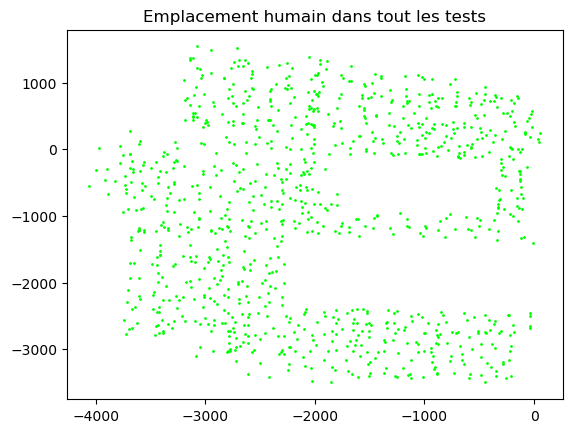

In [8]:
#Montrons avec un graph la répartition des coordonnées de l'humain
#On peut voir des carrés blancs, cela représente par exemple un canapé ou une table
#Où l'humain durant les tests ne pouvait pas se placer
plt.plot([tab_file[0] for tab_file in human_position], [tab_file2[1] for tab_file2 in human_position], linestyle = 'none', marker = 'o', c = 'lime',
  markersize = 1)
plt.title('Emplacement humain dans tout les tests')
plt.show()

In [9]:
#On récupère les données RIR : Room Impulse Response
rir = np.load('data/LivingRoom_preprocessed_hack/Human1/deconvoled_trim.npy')
rir

array([[[ 9.07240337e-06,  1.71257434e-05,  1.22597794e-05, ...,
          8.86178623e-06,  1.40686043e-05,  1.06616626e-05],
        [-8.23853679e-06, -8.23373648e-06, -8.74563466e-06, ...,
          2.87394778e-06, -8.90485808e-06, -3.52464713e-06],
        [ 6.62780906e-07, -1.40201587e-06,  1.83228190e-06, ...,
         -1.06218545e-06,  8.53497477e-06,  2.28155182e-06],
        [ 8.11119719e-07, -2.47451499e-06,  5.82140547e-06, ...,
          7.73804004e-06,  2.29692650e-05,  1.10566034e-05]],

       [[ 1.64466037e-05,  1.53698293e-05,  1.91599720e-05, ...,
          1.76548729e-05,  1.70955263e-05,  1.41169767e-05],
        [ 1.05826217e-07,  9.13145777e-06,  1.76140716e-07, ...,
          1.21369967e-05,  1.55958387e-05,  1.23088676e-05],
        [ 7.06836090e-06,  3.26818258e-06,  7.15508941e-06, ...,
          4.64980394e-06,  8.96262554e-06,  6.55734584e-06],
        [-3.18089551e-05, -8.93297238e-06, -2.51026504e-05, ...,
         -7.02741545e-07,  1.34268867e-05,  3.24307

In [10]:
#Regardons plus en détail la data rir
len(rir[0])
print(" ")
len(rir[0][0])

print(rir[0])
print(len(rir[0][0]))

 
[[ 9.0724034e-06  1.7125743e-05  1.2259779e-05 ...  8.8617862e-06
   1.4068604e-05  1.0661663e-05]
 [-8.2385368e-06 -8.2337365e-06 -8.7456347e-06 ...  2.8739478e-06
  -8.9048581e-06 -3.5246471e-06]
 [ 6.6278091e-07 -1.4020159e-06  1.8322819e-06 ... -1.0621854e-06
   8.5349748e-06  2.2815518e-06]
 [ 8.1111972e-07 -2.4745150e-06  5.8214055e-06 ...  7.7380400e-06
   2.2969265e-05  1.1056603e-05]]
667200


In [74]:
#On applique la méthode RMS, pour Root Mean Square
#Qui permet de donner la moyenne de l'amplitude des sons de rir en 1 seule donnée
#RMS_levels = np.sqrt(np.mean(rir**2, axis=2))
#print(RMS_levels)

[[0.00052505 0.00050232 0.00070836 0.00042991]
 [0.00052084 0.00049965 0.00070709 0.0004291 ]
 [0.00052198 0.00049891 0.00070534 0.00042922]
 ...
 [0.0005181  0.00049532 0.00068871 0.00042133]
 [0.00051583 0.00049072 0.0006886  0.00041962]
 [0.00051578 0.00049757 0.00041044 0.00035783]]


In [83]:
from sklearn.decomposition import PCA

X_reshaped = rir.reshape(1000, -1)
pca = PCA(n_components=100)
RMS_levels = pca.fit_transform(X_reshaped)
print(RMS_levels)

[[ 7.74979070e-02 -2.58192927e-01  3.62292171e-01 ...  1.45750516e-03
  -8.23309552e-03  9.05178394e-03]
 [ 7.22536594e-02 -2.70455539e-01  3.29992682e-01 ...  6.74109813e-03
  -6.14324163e-05  8.09014216e-03]
 [ 6.03799857e-02 -2.51959920e-01  3.55570495e-01 ...  6.01425208e-03
   1.02072954e-02  2.52332445e-03]
 ...
 [-2.49917820e-01  4.55421597e-01  1.10712633e-01 ...  1.19040342e-05
   5.87015925e-03  1.26465538e-03]
 [-2.48996675e-01  4.34803158e-01  9.02627558e-02 ... -1.98135749e-04
  -2.58418499e-03  2.29443749e-03]
 [-3.92814316e-02  3.87486458e-01  3.13313752e-02 ...  1.53222997e-02
   1.53584899e-02 -1.25190765e-02]]


In [84]:
#On normalise les RMS pour le KNN
#On utilise le StandardScaler
scaler = StandardScaler()
normalized_RMS = scaler.fit_transform(RMS_levels)
print(normalized_RMS)

[[ 2.2402129e-01 -1.0359274e+00  1.7474079e+00 ...  1.2012823e-01
  -6.8508226e-01  7.5788718e-01]
 [ 2.0886187e-01 -1.0851278e+00  1.5916210e+00 ...  5.5560499e-01
  -5.1119281e-03  6.7737097e-01]
 [ 1.7453896e-01 -1.0109192e+00  1.7149879e+00 ...  4.9569792e-01
   8.4935683e-01  2.1127310e-01]
 ...
 [-7.2243071e-01  1.8272550e+00  5.3398991e-01 ...  9.8095695e-04
   4.8846039e-01  1.0588743e-01]
 [-7.1976799e-01  1.7445291e+00  4.3535608e-01 ... -1.6330643e-02
  -2.1503212e-01  1.9210888e-01]
 [-1.1354967e-01  1.5546839e+00  1.5111837e-01 ...  1.2628726e+00
   1.2779917e+00 -1.0481951e+00]]


In [85]:
#On divise les données en données d'entrainement pour notre Knn
#Et en donnée de test pour tester notre entrainement de Knn pour voir si il arrive bien à prédire
#On prend 80% d'entrainement et 20% de test
X_train, X_test, y_train, y_test = train_test_split(normalized_RMS, human_position, test_size=0.2, random_state=42)

In [86]:
#On initialise notre Knn en prenant en compte 3 voisins
k = 3
knn = KNeighborsRegressor(n_neighbors=k, weights='distance')
knn.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=3, weights='distance')

In [87]:
#Avec notre Knn, on essaye de prédire la position de l'humain sur toutes les données de test
#predicted_position = knn.predict(query_RMS)
predicted_position = knn.predict(X_test)
print("Predicted human position:", predicted_position)

Predicted human position: [[-1.10177255e+03  2.51250542e+02]
 [-2.36117160e+03 -1.45137880e+03]
 [-1.47024880e+03 -1.56352013e+03]
 [-2.65308138e+03 -1.64186920e+03]
 [-1.81252326e+03 -2.53538455e+03]
 [-2.58719364e+03  8.58523124e+02]
 [-1.64377046e+03 -2.82357019e+03]
 [-8.15141441e+02  4.22680352e+02]
 [-1.28434995e+03 -3.30441900e+03]
 [-6.21594444e+02  6.60034350e+02]
 [-7.56827059e+01  5.10439550e+02]
 [-2.72892292e+03 -8.03002950e+02]
 [-1.39626034e+03 -2.99096095e+03]
 [-1.45743389e+03 -2.68085237e+03]
 [-4.39280969e+02 -2.72947621e+03]
 [-3.30727365e+03 -2.98498061e+02]
 [-1.49470072e+03 -8.48720183e+00]
 [-1.50537321e+03  3.67061245e+02]
 [-2.84861232e+03 -2.11299015e+03]
 [-3.43399062e+03 -2.17049461e+03]
 [-3.42253616e+03 -2.43093213e+03]
 [-2.82999416e+02 -4.23509341e+02]
 [-3.30481218e+03 -3.61966777e+02]
 [-1.29212665e+03  5.36015876e+02]
 [-8.64577411e+02 -1.20034665e+03]
 [-2.51876367e+03 -2.49320194e+03]
 [-2.23776914e+03  9.40302229e+02]
 [-1.57055090e+03 -2.93668843

In [88]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

mse = mean_squared_error(y_test, predicted_position)
mae = mean_absolute_error(y_test, predicted_position)
r2 = r2_score(y_test, predicted_position)

print("Test MSE : ", mse)
print("Test MAE : ", mae)
print("Test R2 : ", r2)

Test MSE :  302483.81910503993
Test MAE :  338.4912462690717
Test R2 :  0.7954160662906766


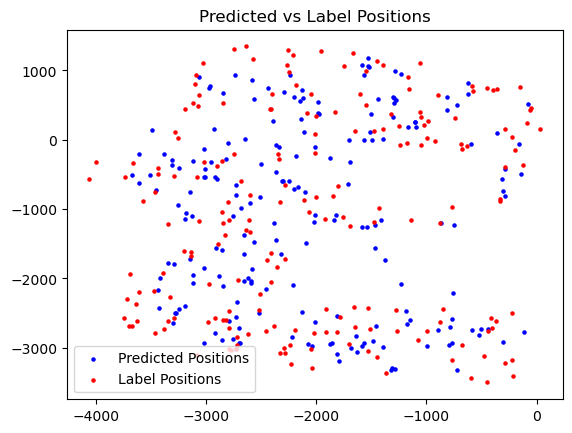

In [89]:
#On montre un graph représentant la chambre, avec :
# - En point bleu, les positions humaines que notre Knn à prédit
# - En point rouge, les vraies positions des humains dans chaque test
plt.scatter(predicted_position[:, 0], predicted_position[:, 1], color='blue', label='Predicted Positions', s=5)
plt.scatter(y_test[:, 0], y_test[:, 1], color='red', label='Label Positions', s=5)
plt.title('Predicted vs Label Positions')
plt.legend()
plt.show()

In [90]:
#Donne le pourcentage de bon résultat en fonction d'une intervalle
#L'intervalle définit le degré d'acceptation pour dire si la coordonée prédite est la même que celle du test
#Par exemple, avec un intervalle de 500, on accepte que la coordonée puisse être à 50cm d'écart maximum de celle initiale
good_result = 0
intervalle = 500
for i in range(0, len(predicted_position)):
    if predicted_position[i][0] > y_test[i][0] - intervalle and predicted_position[i][0] < y_test[i][0] + intervalle:
        if predicted_position[i][1] > y_test[i][1] - intervalle and predicted_position[i][1] < y_test[i][1] + intervalle:
            good_result += 1

print("Le pourcentage de bonnes prédictions est de : " + str(good_result / len(predicted_position)))

Le pourcentage de bonnes prédictions est de : 0.68


In [91]:
#Donne la distance Euclidienne moyenne entre les labels et les valeurs prédite en mm
#eucl = np.sqrt(np.mean((predicted_position - y_test)**2))
#print(eucl)
def euclidean_distance(predicted_position, y_test):
    diff = y_test - predicted_position
    dist = np.linalg.norm(diff, axis=1)
    return dist

disst = euclidean_distance(y_test, predicted_position)
mean_dist = np.mean(disst)

print(mean_dist)

542.7348805281734


Ici, avec 